# Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import KBinsDiscretizer

In [86]:
db= pd.read_csv('processed_data.csv')
print(db)

     Gender  AGE  Urea    Cr  HbA1c  Chol   TG  HDL  LDL  VLDL   BMI  CLASS
0         1   50   4.7  46.0    4.9   4.2  0.9  1.9  1.4   0.5  24.0      0
1         0   26   4.5  62.0    4.9   3.7  1.4  1.1  2.1   0.6  23.0      0
2         1   50   4.7  46.0    4.9   4.2  0.9  1.9  1.4   0.5  24.0      0
3         1   50   4.7  46.0    4.9   4.2  0.9  1.9  1.4   0.5  24.0      0
4         0   33   7.1  46.0    4.9   4.9  1.0  0.8  2.0   0.4  21.0      0
..      ...  ...   ...   ...    ...   ...  ...  ...  ...   ...   ...    ...
995       0   71   8.7  97.0    7.0   7.5  1.7  1.2  1.8   0.6  30.0      2
996       0   31   3.0  60.0   12.3   4.1  2.2  0.7  2.4   2.7  37.2      2
997       0   30   7.1  81.0    6.7   4.1  1.1  1.2  2.4   2.7  27.4      2
998       0   38   5.8  59.0    6.7   5.3  2.0  1.6  2.9   2.7  40.5      2
999       0   54   5.0  67.0    6.9   3.8  1.7  1.1  3.0   0.7  33.0      2

[1000 rows x 12 columns]


# Feature Selection & Discretization

In [87]:
strong_features = ['AGE', 'BMI', 'HbA1c', 'CLASS']
data_strong = db[strong_features]

X = db.drop('CLASS', axis=1)
y = db['CLASS']
num_features = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X[num_features] = kbd.fit_transform(X[num_features])

c:\Users\abdel\anaconda3\envs\py12\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


# Decision Tree — Parameter Grid & Train-Test Split

In [88]:

# --- 1. Define the Parameter Grid ---
# We will test various settings to find the optimal Decision Tree
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
param_grid = {
    'criterion': ['gini', 'entropy'], # How the quality of a split is measured
    'max_depth': [3, 5, 7, 9, 12, None], # Max depth of the tree (None = unlimited)
    'min_samples_leaf': [1, 5, 10, 15], # Minimum samples required to be at a leaf node
}

# Decision Tree — GridSearchCV Setup

In [89]:
# --- 2. Setup the Model and Search ---
dtc = DecisionTreeClassifier(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

# Initialize GridSearchCV
# scoring='accuracy' is the default and appropriate here
grid_search_all = GridSearchCV(
    estimator=dtc, 
    param_grid=param_grid, 
    cv=kf, 
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1 # Use all processors for faster tuning
)

# Decision Tree — Run GridSearchCV & Evaluate

In [90]:
# --- 3. Run the Tuning and Evaluate ---
print("Tuning Decision Tree on ALL Features...")
# X and y are the pre-processed full feature set
grid_search_all.fit(X_train, y_train)

print("\nResults of ALL Features (Tuned Decision Tree):")
print(f"Best Mean Cross-Validation Score: {grid_search_all.best_score_:.4f}")
print(f"Best Parameters: {grid_search_all.best_params_}")

#testing the best model with the Best parameters

best_dc=grid_search_all.best_estimator_
y_pred = best_dc.predict(X_test)
test_accuracy = best_dc.score(X_test, y_test)
print("Final Test Accuracy:", test_accuracy)

Tuning Decision Tree on ALL Features...
Fitting 5 folds for each of 48 candidates, totalling 240 fits



Results of ALL Features (Tuned Decision Tree):
Best Mean Cross-Validation Score: 0.9425
Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5}
Final Test Accuracy: 0.97


# Confusion Matrix & Classification Report — Decision Tree (All Features)


Classification Report:
              precision    recall  f1-score   support

         Non       0.91      1.00      0.95        21
     Predict       0.75      0.60      0.67        10
    Diabetic       0.99      0.99      0.99       169

    accuracy                           0.97       200
   macro avg       0.88      0.86      0.87       200
weighted avg       0.97      0.97      0.97       200



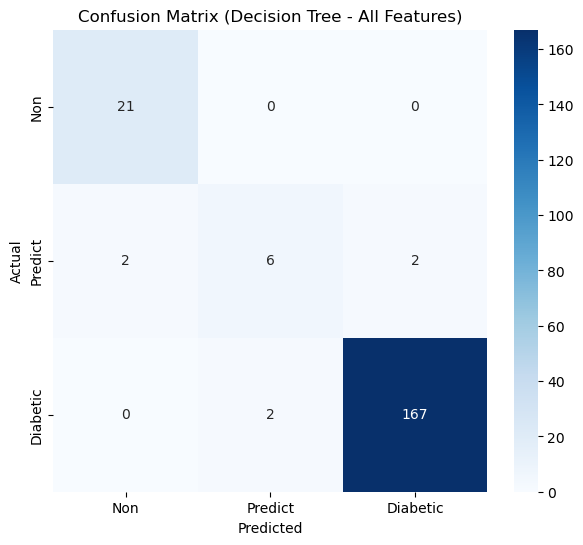

In [91]:
# Confusion matrix
cm_dc = confusion_matrix(y_test, y_pred)
# Classification report (Precision, Recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non', 'Predict', 'Diabetic']))

# ----- Plot Confusion Matrix -----
plt.figure(figsize=(7, 6))
sns.heatmap(cm_dc, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non', 'Predict', 'Diabetic'],
            yticklabels=['Non', 'Predict', 'Diabetic'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Decision Tree - All Features)")
plt.show()


#  Decision Tree — Strong Features Preprocessing & Parameter Grid

In [92]:
X_strong_decision = data_strong.drop('CLASS', axis=1)
y_strong_decision = data_strong['CLASS']
num_strong_features = ['AGE', 'BMI', 'HbA1c']
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_strong_decision[num_strong_features] = kbd.fit_transform(X_strong_decision[num_strong_features])
# Train-test split (for final evaluation)
X_train_strong, X_test_strong, y_train_strong, y_test_strong = train_test_split(
    X_strong_decision, y_strong_decision, test_size=0.2, random_state=42, stratify=y_strong_decision
)
# ------------------- Strong Features -------------------------

X_train_strong, X_test_strong, y_train_strong, y_test_strong = train_test_split(
    X_strong_decision, y_strong_decision, test_size=0.2, random_state=42, stratify=y_strong_decision
)

# Parameter grid for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, 12, None],
    'min_samples_leaf': [1, 5, 10, 15],
}


c:\Users\abdel\anaconda3\envs\py12\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


# Decision Tree — GridSearchCV & Evaluation (Strong Features)

In [93]:
# K-Folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search_strong = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=kf,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Run the tuning and evaluate
print("Tuning Decision Tree on STRONG Features...")
grid_search_strong.fit(X_train_strong, y_train_strong)

print("\nResults of STRONG Features (Tuned Decision Tree):")
print(f"Best Mean Cross-Validation Score: {grid_search_strong.best_score_:.4f}")
print(f"Best Parameters: {grid_search_strong.best_params_}")

# Testing the best model on the test set
best_dt_strong = grid_search_strong.best_estimator_
y_pred_strong = best_dt_strong.predict(X_test_strong)
test_accuracy_strong = best_dt_strong.score(X_test_strong, y_test_strong)
print("Final Test Accuracy:", test_accuracy_strong)

Tuning Decision Tree on STRONG Features...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Results of STRONG Features (Tuned Decision Tree):
Best Mean Cross-Validation Score: 0.9350
Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1}
Final Test Accuracy: 0.975


# Confusion Matrix & Classification Report — Decision Tree (Strong Features)


Classification Report:
              precision    recall  f1-score   support

         Non       0.88      1.00      0.93        21
     Predict       0.88      0.70      0.78        10
    Diabetic       0.99      0.99      0.99       169

    accuracy                           0.97       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.98      0.97      0.97       200



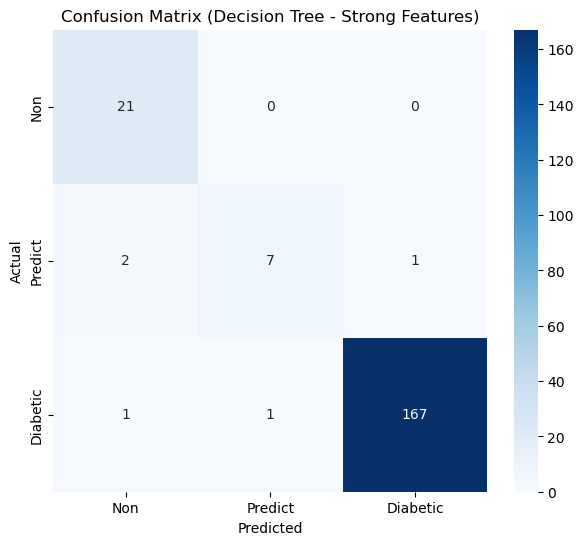

In [95]:
# Confusion matrix
cm_dc_strong = confusion_matrix(y_test_strong, y_pred_strong)
# Classification report
print("\nClassification Report:")
print(classification_report(y_test_strong, y_pred_strong, target_names=['Non', 'Predict', 'Diabetic']))

# Plot Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm_dc_strong, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non', 'Predict', 'Diabetic'],
            yticklabels=['Non', 'Predict', 'Diabetic'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Decision Tree - Strong Features)")
plt.show()

# Conclusion

"Model Performance"

  -All Features: The Decision Tree achieved very high cross-validation and test accuracy, showing strong predictive power when all features are included.

  -Strong Features (AGE, BMI, HbA1c): Performance remained very high and comparable to using all features, indicating these three features capture most of the predictive information.

"Feature Importance & Dimensionality"

  -Using only strong features reduces model complexity and computational cost.

  -Simplified models are easier to interpret and still maintain high accuracy.

"Evaluation Metrics"

  -Precision, Recall, and F1-scores were consistently high across all classes for both all features and strong features.

  -Confusion matrices confirm that the model correctly classifies the majority of instances across Non, Predict, and Diabetic classes.

"Recommendation"

  -For practical applications, using strong features is sufficient and efficient.

  -Decision Tree provides excellent performance and interpretability, making it suitable for clinical or predictive applications.